## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [4]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
print(cv2.__version__)

4.11.0


## Загружаем исходные данные

In [5]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [6]:
# посмотрим на размерность
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train_X[:, 1:], (train_X.shape[0], 28, 28)).astype('float64')
test_img = np.resize(test_X, (test_X.shape[0], 28, 28)).astype('float64')

## Визуализируем исходные данные

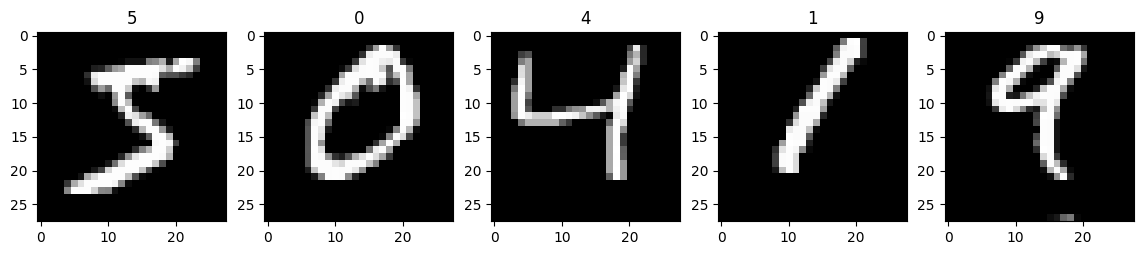

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [9]:
# зададим размер окна
ksize = 7

In [10]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

In [11]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

## Вычисляем угол и длину вектора градиента

In [12]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [13]:
train_g.shape, train_theta.shape, type(train_g)

((60000, 28, 28), (60000, 28, 28), numpy.ndarray)

In [14]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [15]:
train_g.shape

(60000, 28, 28)

In [27]:
# соберем все вместе
#X_train = cv2.merge([train_g, train_theta])
#X_test = cv2.merge((test_g, test_theta))
X_train = train_theta
X_test = test_theta
y_train = train_y
X_train.shape, X_test.shape, y_train.shape

((60000, 28, 28), (10000, 28, 28), (60000,))

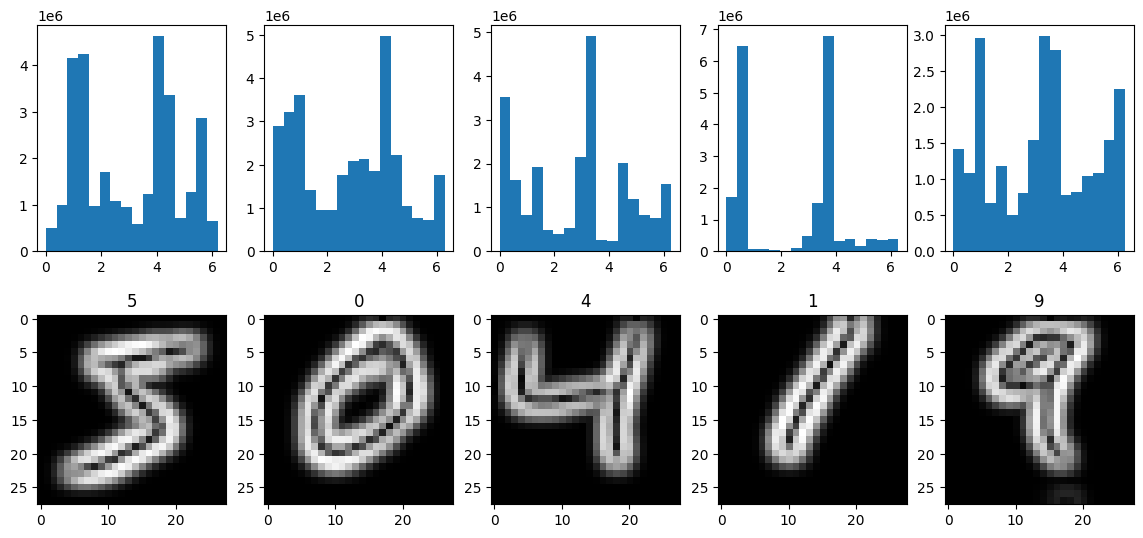

In [17]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Построим сеточку для распознавания

In [3]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [ ]:
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(28,28))

# зададим 1-ю цепочку

# объединим
#merged = L.concatenate([way_1, way_2, way_3, way_4])
merged = L.Flatten()(input_shape)

# добавим полносвязные слои
out = L.Dense(256, activation='relu')(merged)
out = L.BatchNormalization()(out)
out = L.Dense(128, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(32, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_model')

In [23]:
# посмотрим
model.summary()

Model: "My_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         401,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 440,682 (1.68 MB)

 Trainable params: 439,850 (1.68 MB)

 Non-trainable params: 832 (3.25 KB)

In [25]:
# зададим параметры
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 32
learning_rate = 0.1
batch_size = 16
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=None,
          #callbacks=[reduce_lr],
          validation_split=0.2
)

Epoch 1/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 2.3770 - sparse_categorical_accuracy: 0.1027 - val_loss: 18430160.0000 - val_sparse_categorical_accuracy: 0.0959
Epoch 2/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 2.4077 - sparse_categorical_accuracy: 0.1013 - val_loss: 337048672.0000 - val_sparse_categorical_accuracy: 0.0984
Epoch 3/32
1063/3000 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2.3842 - sparse_categorical_accuracy: 0.1073

KeyboardInterrupt: 

## Вычисляем центроиды каждого из 10 классов

In [ ]:
"""
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)
"""

In [ ]:
"""
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)
    ""'

In [ ]:
train_centroids = []
for i in range(train_hist.shape[0]):
    train_centroids.append(np.mean(train_hist[i]))

In [ ]:
len(train_centroids)

In [ ]:
test_centroids = []
for i in range(test_hist.shape[0]):
    test_centroids.append(np.mean(test_hist[i]))

In [ ]:
len(test_centroids)

## Находим ближайший центройд для валидации

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
"""
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_y, centroids,
                                                  test_size=0.2,
                                                  random_state=42)
                                                  """

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
import pandas as pd

In [ ]:
X_train, X_test, y_train, y_test = train_centroids, test_centroids, train_y, test_y

X_train = pd.DataFrame(train_centroids)
X_test = pd.DataFrame(test_centroids)
y_train = pd.DataFrame(train_y)
y_test = pd.DataFrame(test_y)

# Splitting training and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 0)

# Creating the Nearest Centroid Classifier
model = NearestCentroid()

# Training the classifier
model.fit(X_train, y_train.values.ravel())


# Printing Accuracy on Training and Test sets
print(f"Training Set Score : {model.score(X_train, y_train) * 100} %")
print(f"Test Set Score : {model.score(X_test, y_test) * 100} %")

# Printing classification report of classifier on the test set set data
print(f"Model Classification Report : \n{classification_report(y_test, model.predict(X_test))}")

In [ ]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

## Предсказания на тестовыйх данных

In [ ]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

In [ ]:
# Your submission scored 0.41700